## Описание

К нам приходит руководитель продукта “Интернет-магазин”, спрашивает про удержание клиентов и повторные покупки.
У него есть опасение, что из-за проблем с доставкой товаров в магазине у нас стали больше оттекать пользователи.
Он просит нас сравнить, на сколько сейчас все хуже, чем в прошлом году? 

Нам необходимо сделать:
- Проверить гипотезу руководителя продукта 
- Дать руководителю продукта инструмент для самостоятельного принятия решений по качеству удержания пользовательской базы

---

Задачи от руководителя намекают на то, что нам нужно посмотреть на когорты (провести когортный анализ) по различным срезам.

Когортный анализ — это один из методов исследования поведения потребителей. Он показывает, как ведут себя узкие группы людей (когорты), которые совершили определенное действие в какой-то конкретный промежуток времени.

---

[ссылка на разбор](https://www.youtube.com/watch?v=AA0pD2nSB-k&list=PLMv83iwSomR1uCER1zRXTH80X64DgwvD5&index=2)

## Импорт библиотек

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

## Обработка Данных

In [4]:
df_orders = pd.read_csv('orders.csv')
df_orders.sample(3)

,id,order_date,ship_mode,customer_id,sales
448,136742,2014-04-06,Standard,GP-14740,44.91
264,122217,2014-11-24,Standard,HP-14815,111.15
3284,123659,2017-02-10,First,MN-17935,23.12


In [5]:
df_customers = pd.read_csv('customers.csv')
df_customers.sample(3)

,id,name,segment,state,city
237,CK-12205,Chloris Kastensmidt,Consumer,Pennsylvania,Philadelphia
704,DH-13075,Dave Hallsten,Corporate,Kentucky,Richmond
375,DG-13300,Deirdre Greer,Corporate,Pennsylvania,Philadelphia


---

In [6]:
df_orders['order_date'] = df_orders['order_date'].apply(pd.to_datetime)
df_orders['order_year'] = df_orders['order_date'].apply(lambda x: x.year)
df_orders['order_quarter'] = df_orders['order_date'].apply(lambda x: x.to_period('Q'))
df_orders['order_month'] = df_orders['order_date'].apply(lambda x: x.strftime("%Y-%m"))
df_orders = df_orders.drop(['id'], axis=1)
df_orders.sample(3)

,order_date,ship_mode,customer_id,sales,order_year,order_quarter,order_month
1109,2015-10-30,Second,CH-12070,299.900,2015,2015Q4,2015-10
2165,2016-07-16,Second,MC-17425,9.552,2016,2016Q3,2016-07
3585,2017-09-13,Standard,SG-20605,15.920,2017,2017Q3,2017-09


In [7]:
df_customers.rename(columns={'id': 'customer_id'}, inplace=True)
df_customers.sample(3)

,customer_id,name,segment,state,city
548,AS-10090,Adam Shillingsburg,Consumer,Virginia,Charlottesville
320,CM-12445,Chuck Magee,Consumer,California,San Francisco
721,LS-17230,Lycoris Saunders,Consumer,Delaware,Dover


---

In [8]:
df = pd.merge(df_orders, df_customers, 'inner', on='customer_id')
df.sample(3)

,order_date,ship_mode,customer_id,sales,order_year,order_quarter,order_month,name,segment,state,city
1259,2017-01-12,Second,DA-13450,77.76,2017,2017Q1,2017-01,Dianna Arnett,Home Office,Texas,Houston
3308,2017-06-19,Standard,AR-10405,200.94,2017,2017Q2,2017-06,Allen Rosenblatt,Corporate,Massachusetts,Franklin
5003,2017-07-03,Standard,CS-12460,311.96,2017,2017Q3,2017-07,Chuck Sachs,Consumer,Georgia,Columbus


---

In [15]:
# для каждого пользователя ищем минимальное значение order_date
df_firstorder = df[['customer_id', 'order_date']].groupby('customer_id').order_date.min().reset_index()

# берем год, квартал, год-месяц первого заказа
df_firstorder['first_order_year'] = df_firstorder['order_date'].apply(lambda x: x.year)
df_firstorder['first_order_quarter'] = df_firstorder['order_date'].apply(lambda x: x.to_period('Q'))
df_firstorder['first_order_month'] = df_firstorder['order_date'].apply(lambda x: x.strftime("%Y-%m"))

# order_date уже не необходим (во избежании дубликатов)
df_firstorder = df_firstorder.drop(['order_date'], axis=1)

pd.merge(df, df_firstorder, 'inner', on='customer_id').sample(3)

,order_date,ship_mode,customer_id,sales,order_year,order_quarter,order_month,name,segment,state,city,first_order_year,first_order_quarter,first_order_month
3079,2017-11-11,First,MH-18025,88.92,2017,2017Q4,2017-11,Michelle Huthwaite,Consumer,Washington,Seattle,2014,2014Q3,2014-07
4273,2017-09-21,First,ML-18265,151.96,2017,2017Q3,2017-09,Muhammed Lee,Consumer,Washington,Seattle,2015,2015Q2,2015-05
4676,2017-04-14,First,CL-12700,8.76,2017,2017Q2,2017-04,Craig Leslie,Home Office,Missouri,Springfield,2016,2016Q2,2016-04


In [10]:
# запишем это в функцию
def get_crosstab(df):
    df_firstorder = df[['customer_id', 'order_date']].groupby('customer_id').order_date.min().reset_index()
    df_firstorder['first_order_year'] = df_firstorder['order_date'].apply(lambda x: x.year)
    df_firstorder['first_order_quarter'] = df_firstorder['order_date'].apply(lambda x: x.to_period('Q'))
    df_firstorder['first_order_month'] = df_firstorder['order_date'].apply(lambda x: x.strftime("%Y-%m"))
    df_firstorder = df_firstorder.drop(['order_date'], axis=1)
    return pd.merge(df, df_firstorder, 'inner', on='customer_id')

## Создание Таблицы с Когортами

In [12]:
def get_retention(df, metric_name, cohort, flag, dop_name = ''):
    '''
    Calc retention and show heat map
        metric_name -- метрику для расчета и аггрегации
        cohort -- период для аггрегации (order_year, order_quarter, order_month)
        flag -- маркер типа отношений в таблице
        dop_name -- если хотим добавить информацию в заголовок графика
    '''
    df = get_crosstab(df)
    
    if metric_name == 'Customer':
        cohorts_group = df.groupby(['first_' + cohort, cohort]).agg({'customer_id': pd.Series.nunique})
        cohorts_group.rename(columns={'customer_id': metric_name}, inplace=True)
    elif metric_name == 'Sales':
        cohorts_group = df.groupby(['first_' + cohort, cohort]).agg({'sales': pd.Series.sum})
        cohorts_group.rename(columns={'sales': metric_name}, inplace=True)
    elif metric_name == 'Avg sales':
        cohorts_group = df.groupby(['first_' + cohort, cohort]).agg({'sales': pd.Series.mean})
        cohorts_group.rename(columns={'sales': metric_name}, inplace=True)
    elif metric_name == 'Order':
        cohorts_group = df.groupby(['first_' + cohort, cohort]).agg({'customer_id': pd.Series.count})
        cohorts_group.rename(columns={'customer_id': metric_name}, inplace=True)
    
    cohorts = cohorts_group.copy()
    cohorts.reset_index(inplace=True)
    cohorts_set = set(cohorts[cohort])
    cohorts = pd.DataFrame({cohort:sorted(list(cohorts_set)),'CohortPeriod': range(len(cohorts_set))})
    

    cohorts_group.reset_index(inplace=True)

    ###
    cohorts_group = pd.merge(cohorts_group, cohorts, 'left' , cohort)
    cohorts.rename(columns={cohort: 'first_' + cohort}, inplace=True)
    cohorts_group = pd.merge(cohorts_group, cohorts, 'left' , 'first_' + cohort).fillna(0)
    if flag:
        cohorts_group['CohortPeriod'] = cohorts_group['CohortPeriod_x'] - cohorts_group['CohortPeriod_y']
    else:
        cohorts_group['CohortPeriod'] = cohorts_group['CohortPeriod_x']
    ####
    
    
    cohorts_group.set_index(['first_' + cohort , 'CohortPeriod'], inplace=True) 
    cohort_group_size = cohorts_group[metric_name].groupby(level=0).first()
    user_retention = cohorts_group[metric_name].unstack(0).divide(cohort_group_size, axis=1).T
    user_retention[0] = cohort_group_size
    
    sns.set(style='white')
    plt.figure(figsize=(24, 16))
    plt.title('Cohorts: ' + metric_name + ' retention by ' + cohort[6:] + ' ' + dop_name, fontsize = 25)
    
    if cohort == 'order_month':
        fmt='.2g'
        annot_kws={"size":0}
    elif cohort == 'order_quarter':
        fmt='.3g'
        annot_kws={"size":16}
    elif cohort == 'order_year':
        fmt='g'
        annot_kws={"size":16}
    vmax = max(max(user_retention.loc[:,1:].max()),1)
    
    sns.heatmap(user_retention, mask=user_retention.isnull(), annot=True, fmt=fmt, vmax=vmax, annot_kws=annot_kws, linewidth=0.5) 

    return user_retention

## Визуализация Графиков

CohortPeriod,0,1,2,3
first_order_year,,,,
2014,595,0.734454,0.815126,0.868908
2015,136,0.750000,0.882353,NaN
2016,51,0.882353,NaN,NaN
2017,11,NaN,NaN,NaN


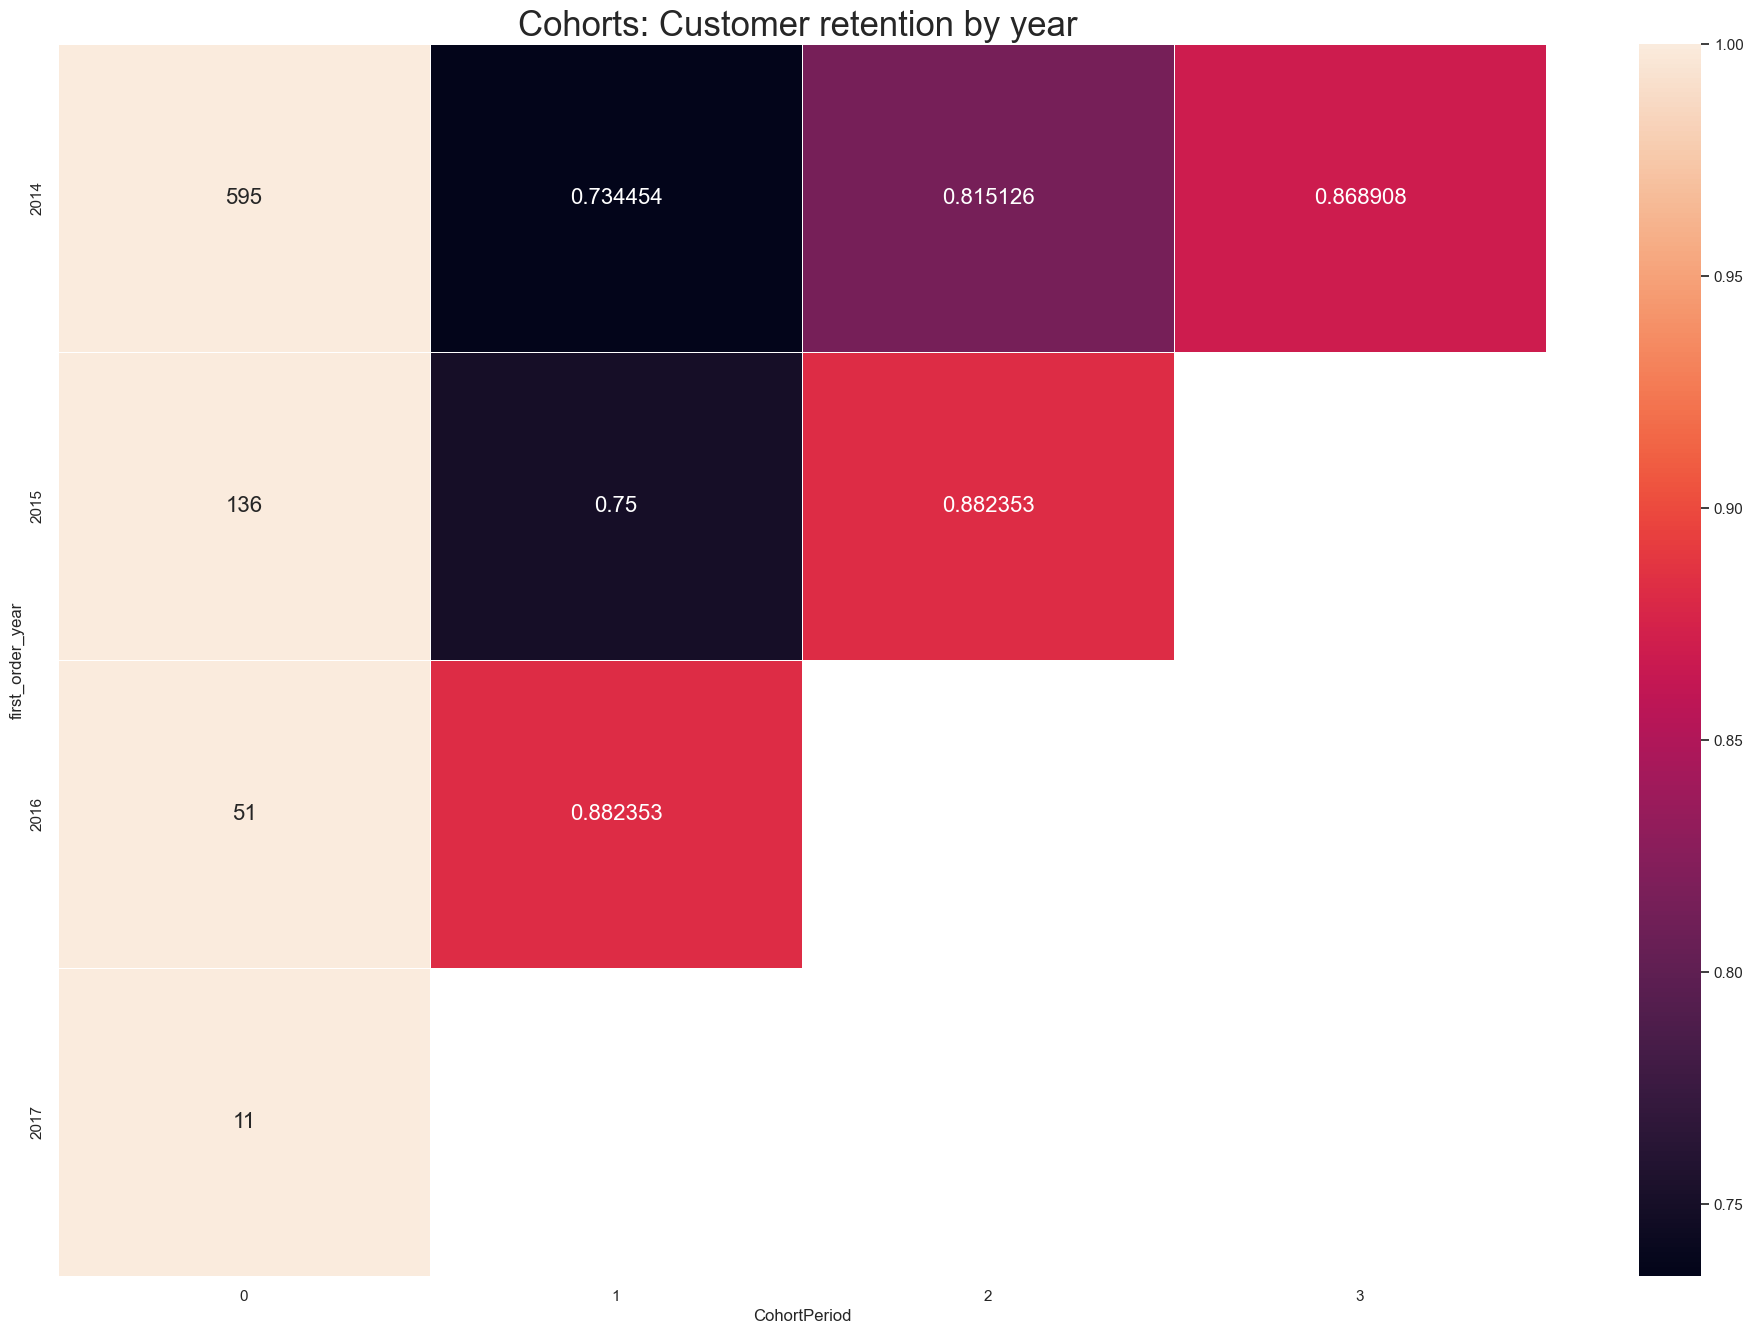

In [23]:
get_retention(df, 'Customer', 'order_year', True)

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
first_order_quarter,,,,,,,,,,,,,,,,
2014Q1,121,0.165289,0.231405,0.338843,0.148760,0.223140,0.272727,0.371901,0.214876,0.280992,0.355372,0.438017,0.280992,0.404959,0.421488,0.545455
2014Q2,160,0.243750,0.362500,0.175000,0.275000,0.293750,0.425000,0.206250,0.318750,0.356250,0.487500,0.231250,0.362500,0.450000,0.531250,NaN
2014Q3,161,0.329193,0.186335,0.285714,0.298137,0.416149,0.186335,0.298137,0.397516,0.434783,0.229814,0.391304,0.447205,0.521739,NaN,NaN
2014Q4,153,0.176471,0.202614,0.313725,0.398693,0.196078,0.326797,0.379085,0.411765,0.274510,0.366013,0.418301,0.620915,NaN,NaN,NaN
2015Q1,32,0.250000,0.312500,0.250000,0.187500,0.187500,0.375000,0.500000,0.375000,0.375000,0.218750,0.500000,NaN,NaN,NaN,NaN
2015Q2,36,0.305556,0.388889,0.277778,0.277778,0.444444,0.444444,0.361111,0.194444,0.555556,0.583333,NaN,NaN,NaN,NaN,NaN
2015Q3,36,0.416667,0.277778,0.222222,0.388889,0.444444,0.250000,0.527778,0.527778,0.416667,NaN,NaN,NaN,NaN,NaN,NaN
2015Q4,32,0.093750,0.156250,0.343750,0.375000,0.375000,0.187500,0.406250,0.531250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016Q1,14,0.428571,0.428571,0.500000,0.571429,0.428571,0.642857,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


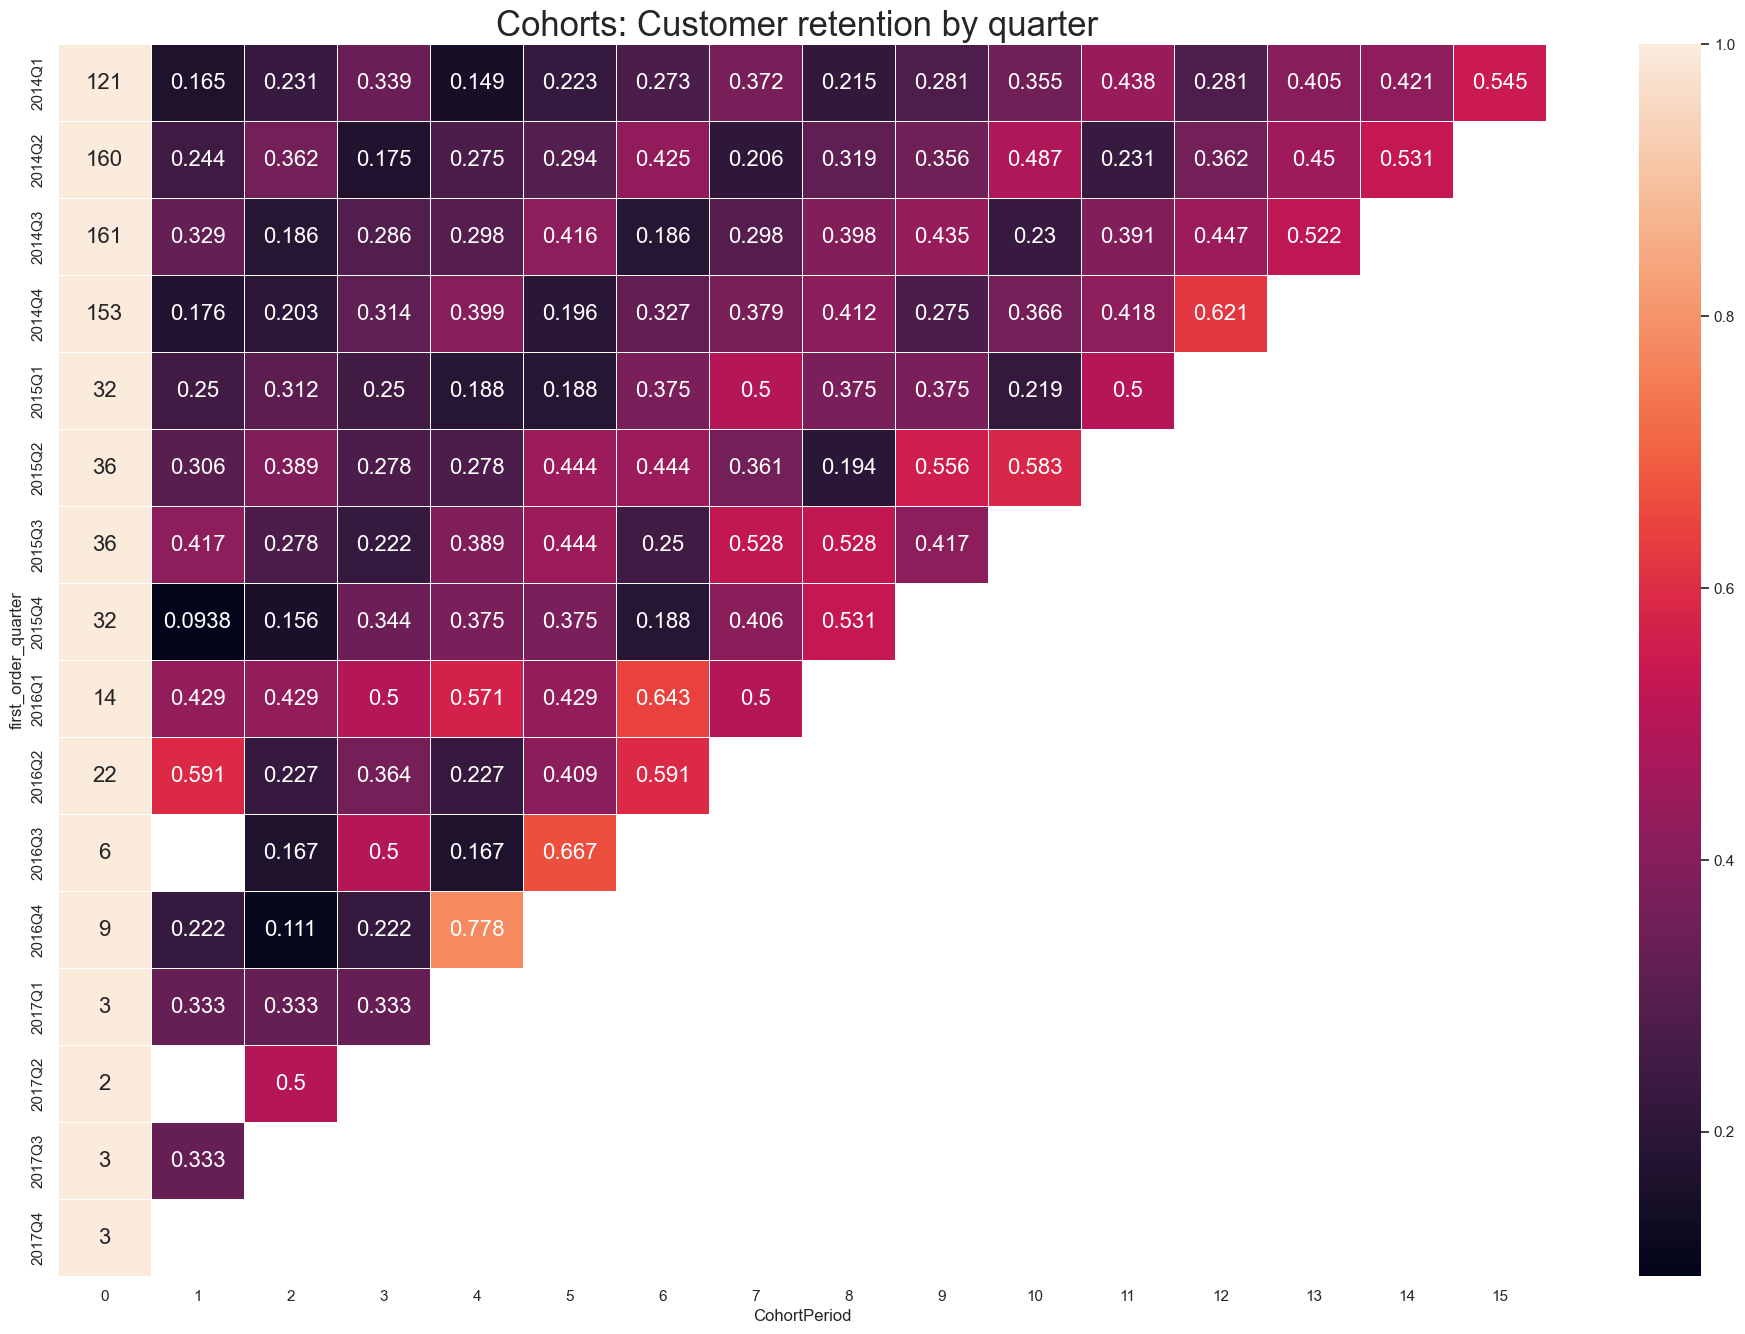

In [18]:
get_retention(df, 'Customer', 'order_quarter', True)

CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
first_order_month,,,,,,,,,,,,,,,,,,,,,
2014-01,32,0.093750,NaN,0.062500,0.062500,NaN,0.062500,0.125000,0.156250,0.093750,...,0.187500,0.125000,0.156250,0.125000,0.031250,0.062500,0.281250,0.281250,0.3125,0.1875
2014-02,24,0.166667,0.083333,0.041667,NaN,0.083333,0.083333,0.125000,0.125000,0.166667,...,0.083333,0.083333,0.208333,0.125000,0.125000,0.166667,0.250000,0.250000,0.1250,NaN
2014-03,65,0.061538,0.030769,0.123077,0.107692,NaN,0.107692,0.076923,0.123077,0.092308,...,0.200000,0.153846,0.184615,0.092308,0.292308,0.123077,0.276923,0.246154,NaN,NaN
2014-04,56,0.107143,0.035714,0.071429,0.053571,0.142857,0.107143,0.160714,0.142857,0.017857,...,0.089286,0.125000,0.142857,0.267857,0.142857,0.250000,0.250000,NaN,NaN,NaN
2014-05,56,0.089286,0.089286,0.071429,0.178571,0.035714,0.214286,0.178571,0.071429,0.053571,...,0.125000,0.107143,0.285714,0.125000,0.303571,0.160714,NaN,NaN,NaN,NaN
2014-06,48,0.020833,0.041667,0.083333,0.041667,0.187500,0.166667,0.020833,0.083333,0.125000,...,0.062500,0.270833,0.145833,0.291667,0.229167,NaN,NaN,NaN,NaN,NaN
2014-07,44,0.136364,0.113636,NaN,0.113636,0.181818,0.045455,NaN,0.181818,0.045455,...,0.250000,0.227273,0.295455,0.204545,NaN,NaN,NaN,NaN,NaN,NaN
2014-08,49,0.163265,0.061224,0.224490,0.102041,0.061224,0.081633,0.040816,0.081633,0.061224,...,0.244898,0.224490,0.204082,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09,68,0.132353,0.132353,0.161765,0.014706,0.029412,0.132353,0.147059,0.132353,0.029412,...,0.235294,0.176471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


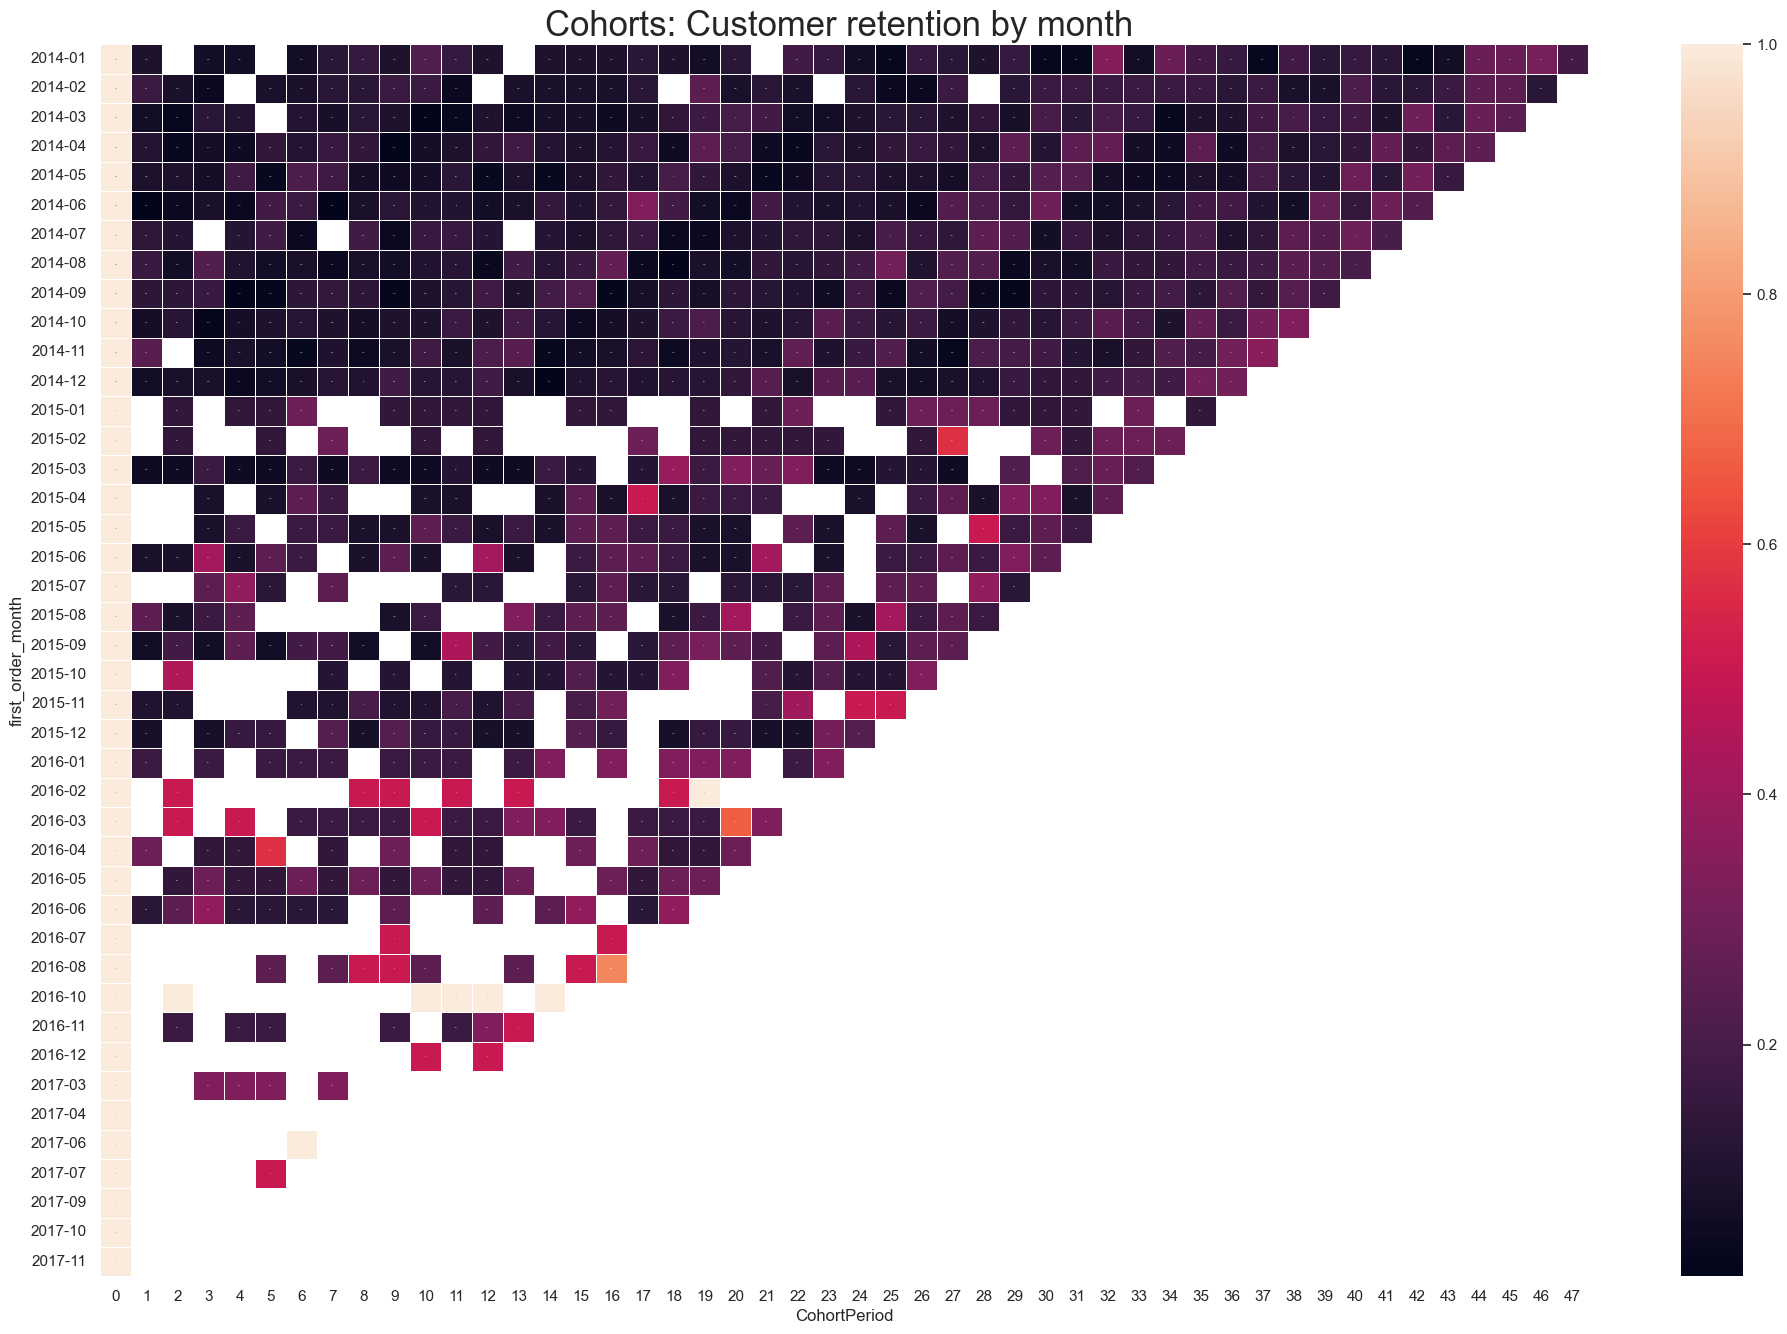

In [19]:
get_retention(df, 'Customer', 'order_month', True)

---

Тут пропущен блок с просмотром остальных графиков. Но это в данном ноутбуке неважно. Главное были представлены функции для использования когортного анализа на практике.

## Выводы

## Ответ
### Ответы на поставленные вопросы:

На сколько сейчас все хуже, чем в прошлом году? 
- Отток клиентов не наблюдается - наоборот, старые клиенты стали делать больше заказов. Повторных заказов в данном году больше, чем в предыдущем. Следовательно, проблемы с доставкой не оказали существенного влияния на эти показатели.

Однако, в ходе исследования обнаружились другие проблемы:
- Приток новых клиентов значительно падает каждый год.
- В данном году средний чек снизился по всем клиентам по сравнению с прошлыми годами.

---